In [1]:
from __future__ import division
import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
import random

import copy
from datasets.maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

#import matplotlib.pyplot as plt

In [2]:
word_filter_len = 1 # only words above this length are considered valid

In [3]:
if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]
#torch.cuda.get_device_name(gpu_id[0])
pass

In [4]:
model_ = torch.load('models/PHOCNet_Nov13.pt')
cnn = model_.module#list(model_.named_parameters())
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])
cnn.training = False

In [5]:
from strlocale import BasicLocale

def clean_words(words):
    lc = BasicLocale()
    for i, w in enumerate(words):
        try:
            words[i] = lc.represent(w).encode('ascii',errors='ignore')
        except:
            words[i] = w
    return words

# load before, after images and words, transforms and cleans them
# the function also assumes that ground truth words are the same before and after
# returns before_images, after_images, words
def load_and_transform(map_name):
    images_before = np.load('../../../detection_outputs_ready_for_test/ray_regions/'+map_name+'.npy')
    words_before = np.load('../../../detection_outputs_ready_for_test/ray_labels/'+map_name+'.npy')
    words_before = clean_words(words_before)
    images_before, words_before = clean_word_images(images_before, words_before)
    images_before = np.transpose(images_before, (0,3,1,2))
    
    images_after = np.load('../../../detection_outputs_ready_for_test/ray_regions_gis/'+map_name+'.npy')
    words_after = np.load('../../../detection_outputs_ready_for_test/ray_labels_gis/'+map_name+'.npy')
    words_after = clean_words(words_after)
    images_after, words_after = clean_word_images(images_after, words_after)
    images_after = np.transpose(images_after, (0,3,1,2))
    
    print 'Images Before Shape ', images_before.shape
    print 'Words Before Shape ', words_before.shape
    print 'Images After Shape ', images_after.shape
    print 'Words After Shape ', words_after.shape
    return images_before, images_after, words_after

def clean_word_images(images, words):
    selected_idx = [x for x in range(len(words)) if len(words[x]) > word_filter_len]
    images = images[selected_idx]
    words = words[selected_idx]
    return images, words

def load_and_clean_gis_data():
    with open('../../../GIS_data/GIS_combined.txt') as f:
        gis_data = np.array(f.read().splitlines())
    gis_data = clean_words(gis_data)
    print 'GIS Data', gis_data.shape
    return gis_data

In [6]:
# # find the file names
# f = open('../splits/val_files.txt', 'rb')
# A = f.readlines()
# f.close()
# A = [x.rstrip('\n') for x in A]

# gl_gt_in_gis = 0
# gl_total = 0
# for i in range(len(A)):
#     im_before, im_after, words, gis = load_and_transform(A[i])
#     gis = set(gis)
#     words = set(words)
#     gt_in_gis = 0
#     total = 0
#     for w in words:
#         if w in gis:
#             gt_in_gis += 1
#         total += 1
#     print 'percentage of words in gs_data ' + str(gt_in_gis/total)
#     gl_gt_in_gis += gt_in_gis
#     gl_total += total
# print 'overall percentage of words in gs_data ' + str(gl_gt_in_gis/gl_total)
    

In [7]:
# convert image tnto embedding using the cnn model
def get_image_embeddings(cnn, images):
    outputs = []
    for i in tqdm(range(len(images))):
        word_img = images[i]
        word_img = 1 - word_img.astype(np.float32) / 255.0
        word_img = word_img.reshape((1,) + word_img.shape)
        word_img = torch.from_numpy(word_img).float()
        word_img = word_img.cuda(gpu_id[0])
        word_img = torch.autograd.Variable(word_img)
        output = torch.sigmoid(cnn(word_img))
        output = output.data.cpu().numpy().flatten()
        outputs.append(output)
    return outputs

In [8]:
# function to create word variations
# word_var is a dictionary that contains all variations as key and 0,1,-1 as value
# 0 denotes the root word, -1 denotes var = root_word[:-1], +1 denotes var = root_word[1:]
# root_word_var is a dict that stores original_word => all_variations
# enable_conf: boolean flag that controls if the confusion logic should be used.
# when enabled if a word is a root word as well as a word variation (happens if root words ar rand and grand)
# it marks it as to be extended and also stores it in the confusion list
def create_word_variations(words, enable_conf=False):
    word_var = {}
    root_word_var = {}
    # create the root word variation dict and set word_var as -1 or +1
    for w in words:
        if len(w) <= word_filter_len:
            continue
        root_var_list = [w, w.lower(), w.upper(), w.capitalize()]
        var_set = set()
        for var in root_var_list:
            word_var[var[1:]] = 1
            word_var[var[:-1]] = -1
            var_set.add(var)
            var_set.add(var[1:])
            var_set.add(var[:-1])
        root_word_var[w] = var_set
    # explicitly set all root words to have direction 0
    # mark the words that already have a direction set
    conf_words = set()
    for w in words:
        if len(w) <= word_filter_len:
            continue
        root_var_list = [w, w.lower(), w.upper(), w.capitalize()]
        for var in root_var_list:
            if var in word_var and word_var[var] != 0 and enable_conf:
                conf_words.add(var)
            else:
                word_var[var] = 0
    return word_var, root_word_var, conf_words

In [9]:
# compute the PHOC representation of the word itself
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor
def get_word_phoc_representations(word_strings):
    unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
    bigram_levels = None
    bigrams = None
    phoc_unigram_levels=(1, 2, 4, 8)
    word_var_dir, root_word_var, conf_words = create_word_variations(word_strings, enable_conf=True)
    
    word_var_strings = word_var_dir.keys()
    embedding_var = build_phoc_descriptor(words=word_var_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)
    
    print('embedding variations:', embedding_var.shape)
    return (embedding_var, word_var_strings, word_var_dir, root_word_var, conf_words)

In [10]:
from scipy.spatial.distance import cdist, pdist, squareform

# gets the actual distances of all the ground truth word variations
def get_all_dist_gt(dist_mat, emb_info, ground_truth):
    # expand emb_info tuple
    embedding_var, word_var_strings, word_var_dir, root_word_var,_ = emb_info
    all_dist = []
    for i in range(len(ground_truth)):
        w_dist = []
        if ground_truth[i] in root_word_var:
            w_vars = root_word_var[ground_truth[i]]
            for j in range(len(word_var_strings)):
                if word_var_strings[j] in w_vars:
                    w_dist.append((word_var_strings[j], dist_mat[i][j]))
        all_dist.append(w_dist)
    return all_dist

# the new report matches method that handles variations
def report_matches_with_variations(dist_mat, ground_truth, emb_info, k):
    # expand emb_info tuple
    embedding_var, word_var_strings, word_var_dir, root_word_var,_ = emb_info
    gt_words_dist = []
    # gt_words_dist = get_all_dist_gt(dist_mat, emb_info, ground_truth)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    img_dir = []
    words_len = []
    actual_dist = []
    min_ext_len = 3
    # get all matched words
    for i in range(len(q)):
        matched = []
        for j in q[i]:
            actual_dist.append(dist_mat[i][j])
            matched.append(word_var_strings[j])
            curr_len = len(word_var_strings[j])
            curr_dir = word_var_dir[word_var_strings[j]]
            if len(ground_truth[i]) < min_ext_len:
                curr_dir = 0
            words_len.append(curr_len + abs(curr_dir))
            img_dir.append(curr_dir)
        matched_words.append(matched)
    
    # calculate accuracies
    is_correct = []
    for i in range(len(ground_truth)):
        #print word_strings[i]
        is_correct.append(0)
        if ground_truth[i].lower() in [mw.lower() for mw in matched_words[i]]:
            is_correct[i] = 1
            count = count+1
        else:
            for w in matched_words[i]:
                if ground_truth[i] in root_word_var and w in root_word_var[ground_truth[i]]:
                    is_correct[i] = 2
                    count = count+1
                    break
    return (count, matched_words, img_dir, words_len, actual_dist, is_correct, gt_words_dist)

# For some images, the original predicted word os both a root word and a word_variation of another word 
# (common word problem). Due to this one cannot be sure, if these images should be extended or not.
# These images are handled by comparing distances before and after image extension and picking the minimum one
# the feature can be turned of by setting enable_conf = False
def update_dist_matrix(dist_mat_before, dist_mat_after, conf_idx):
    print('conf_idx', conf_idx)
    for i in conf_idx:
        dist = np.minimum(dist_mat_before[i], dist_mat_after[i])
        dist_mat_after[i] = dist

In [11]:
def generate_confusion_matrix(match_report_before, match_report_after, words):
    status = [0,1,2]
    conf_matrix = [['before/after','incorrect (0)','correct (1)','almost (2)'],
                   ['incorrect (0)',0,0,0],
                   ['correct (1)',0,0,0],
                   ['almost (2)',0,0,0]]
    for i in status:
        for j in status:
            count = 0
            for k in range(len(words)):
                if match_report_before[5][k] == i and match_report_after[5][k] == j:
                    count += 1
            conf_matrix[1+i][1+j] = count
    return conf_matrix

In [21]:
def save_before_after_preds(map_name, before_report, after_report, ground_truth):
    before_preds = [w[0] for w in before_report[1]]
    after_preds = [w[0] for w in after_report[1]]
    before_after_pred = np.array([before_preds, after_preds, ground_truth]).T
    np.save('../../../before_after_ext_pred/'+map_name+'.npy', before_after_pred)

def compare_images_before_after_ext(map_name, cnn, global_stats, word_emb_info):
    images_before, images_after, words = load_and_transform(map_name)
    image_embs_before = get_image_embeddings(cnn, images_before)
    image_embs_after = get_image_embeddings(cnn, images_after)
    # sample for experiments
#     image_embs_before = image_embs_before[:10]
#     image_embs_after = image_embs_after[:10]
#     words = words[:10]
    # get the distances between images and words
    dist_matrix_before = cdist(XA=image_embs_before, XB=word_emb_info[0], metric='cosine')
    dist_matrix.append(dist_matrix_before)
    print 'before distance calculation done'
    dist_matrix_after = cdist(XA=image_embs_after, XB=word_emb_info[0], metric='cosine')
    dist_matrix.append(dist_matrix_after)
    print 'after distance calculation done'
    # build the original report
    match_report_before = report_matches_with_variations(dist_matrix_before, words, word_emb_info, 1)
    print 'before report created'
    # get the low confidence image index
    conf_idx = [i for i in range(len(match_report_before[1])) if match_report_before[1][i][0] in word_emb_info[4]]
    # update the dist_after matrix based for low confidence images
    update_dist_matrix(dist_matrix_before, dist_matrix_after, conf_idx)
    print 'dist matrix update done'
    # build the report after extension
    match_report_after = report_matches_with_variations(dist_matrix_after, words, word_emb_info, 1)
    print 'after report created'
    # save_before_after_preds(map_name, match_report_before, match_report_after, words)
    global_stats['correct_before'] += match_report_before[0]
    global_stats['correct_after'] += match_report_after[0]
    global_stats['total'] += len(words)
    acc_before = match_report_before[0]/len(words)
    acc_after = match_report_after[0]/len(words)
    conf_matrix = generate_confusion_matrix(match_report_before, match_report_after, words)
    return (acc_before, acc_after, conf_matrix, match_report_before, match_report_after)

In [22]:
# find the file names
# f = open('../splits/val_files.txt', 'rb')
# A = f.readlines()
# f.close()
# A = [x.rstrip('\n') for x in A]
A = ['D0042-1070007']

In [14]:
gis_data = load_and_clean_gis_data()
text_phoc_info = get_word_phoc_representations(gis_data)

GIS Data (477196,)


100%|██████████| 1290899/1290899 [05:52<00:00, 3659.23it/s]

('embedding variations:', (1290899, 945))


In [23]:
dist_matrix = []
global_stats = {'correct_before':0, 'correct_after':0, 'total':0}
local_stats = []
for i in tqdm(range(len(A)), ascii=True, desc='Main Iteration'):
    stats = compare_images_before_after_ext(A[i], cnn, global_stats, text_phoc_info)
    local_stats.append(stats)

Images Before Shape  (1302, 3, 135, 487)
Words Before Shape  (1302,)
Images After Shape  (1302, 3, 135, 487)
Words After Shape  (1302,)


before distance calculation done
after distance calculation done
before report created
('conf_idx', [0, 2, 6, 9, 11, 17, 18, 23, 38, 44, 54, 57, 58, 61, 63, 71, 72, 73, 74, 76, 77, 78, 79, 83, 84, 85, 86, 87, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 105, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 128, 129, 130, 132, 133, 134, 135, 137, 138, 140, 141, 143, 146, 147, 149, 152, 153, 154, 156, 157, 158, 159, 161, 169, 170, 171, 172, 174, 176, 177, 178, 182, 185, 189, 190, 192, 194, 196, 198, 199, 201, 202, 204, 205, 206, 207, 208, 210, 213, 214, 216, 217, 219, 220, 224, 230, 232, 234, 235, 238, 242, 243, 244, 245, 248, 249, 253, 254, 255, 256, 257, 258, 259, 260, 264, 265, 268, 272, 273, 274, 276, 277, 278, 279, 280, 281, 283, 286, 287, 289, 291, 292, 295, 296, 298, 299, 300, 301, 302, 303, 304, 305, 306, 308, 309, 310, 312, 313, 315, 317, 319, 320, 323, 325, 326, 327, 329, 331, 332, 333, 337, 339, 340, 342, 343, 345, 346, 347, 348, 

In [26]:
# print accuracies
for i in range(len(A)):
    print('Accuracy for image '+A[i])
    print "the accuracy before extension: " + str(local_stats[i][0])
    print "the accuracy after extension: "+str(local_stats[i][1])
    print('\n')
    
print 'Overall Accuracy Before ', global_stats['correct_before']/global_stats['total']
print 'Overall Accuracy After', global_stats['correct_after']/global_stats['total']
print global_stats

Accuracy for image D0042-1070007
the accuracy before extension: 0.26420890937
the accuracy after extension: 0.258064516129


Overall Accuracy Before  0.26420890937
Overall Accuracy After 0.258064516129
{'correct_before': 344, 'total': 1302, 'correct_after': 336}


In [27]:
from IPython.display import HTML, display
def print_conf_matrix(conf_matrix):
    display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in conf_matrix)
        )
    ))

# print the confusion matrix
for i in range(len(A)):
    conf_matrix = local_stats[i][2]
    print('Confusion Matrix for Image ' + A[i])
    print_conf_matrix(conf_matrix)
    print('\n')

Confusion Matrix for Image D0042-1070007


before/after,incorrect (0),correct (1),almost (2)
incorrect (0),914,26,18
correct (1),20,262,1
almost (2),32,14,15


In [34]:
acc_before, acc_after, conf_matrix, match_report_before, match_report_after = stats
images_before, images_after, words = load_and_transform(A[0])

Images Before Shape  (1302, 3, 135, 487)
Words Before Shape  (1302,)
Images After Shape  (1302, 3, 135, 487)
Words After Shape  (1302,)
[['before/after', 'incorrect (0)', 'correct (1)', 'almost (2)'], ['incorrect (0)', 914, 26, 18], ['correct (1)', 20, 262, 1], ['almost (2)', 32, 14, 15]]


In [40]:
word_var_dir = text_phoc_info[2]
word_var_dir['Aftan']

KeyError: 'Aftan'

Incorrectly classified before and Incorrectly classified after
************************************************************************
************************************************************************


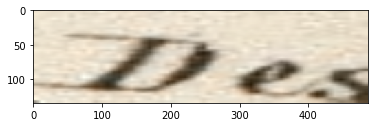

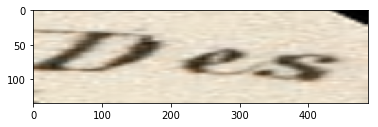

image index 58
Matched before: $Des$
Matched after:$ees$
Ground truth:Des
Image Dir before:-1
Image Dir after:1
Distance before:0.21493999825468935
Distance after:0.07547703081664459
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


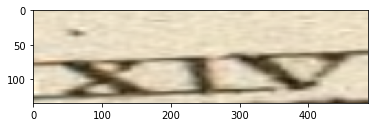

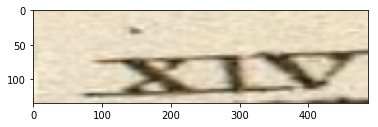

image index 110
Matched before: $XIV$
Matched after:$XXV$
Ground truth:XIV
Image Dir before:1
Image Dir after:-1
Distance before:0.018263990354475346
Distance after:0.00624630474347021
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


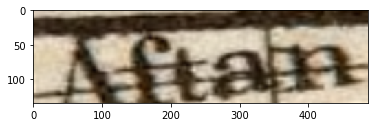

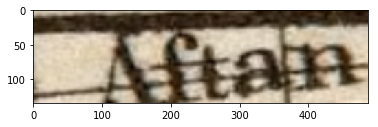

image index 186
Matched before: $aftan$
Matched after:$Astan$
Ground truth:Aftan
Image Dir before:1
Image Dir after:-1
Distance before:0.14119756150066964
Distance after:0.14872169938435653
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


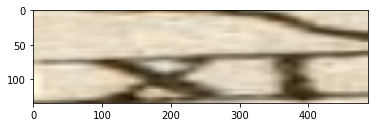

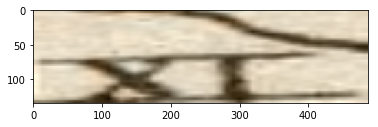

image index 219
Matched before: $XI$
Matched after:$XII$
Ground truth:XI
Image Dir before:0
Image Dir after:0
Distance before:0.12554006259598738
Distance after:0.11419935017683713
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


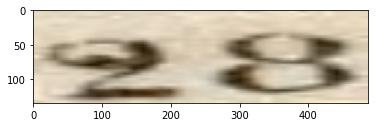

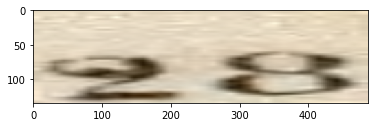

image index 359
Matched before: $28$
Matched after:$3$
Ground truth:28
Image Dir before:0
Image Dir after:0
Distance before:0.07580043495385258
Distance after:0.020653129263448866
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


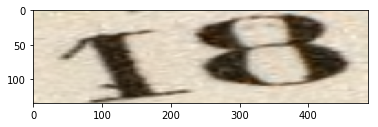

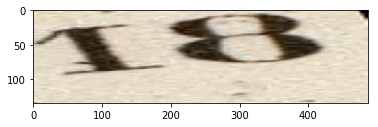

image index 586
Matched before: $18$
Matched after:$313$
Ground truth:18
Image Dir before:0
Image Dir after:0
Distance before:0.25476711822907205
Distance after:0.15786298713615843
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


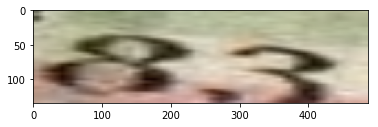

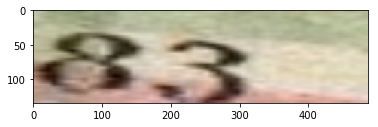

image index 645
Matched before: $83$
Matched after:$883$
Ground truth:83
Image Dir before:0
Image Dir after:0
Distance before:0.2539207356166766
Distance after:0.18402945254982817
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


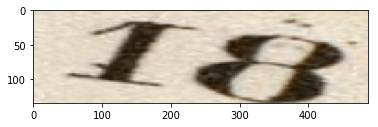

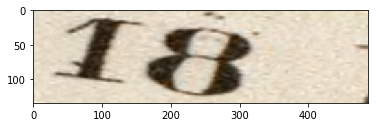

image index 661
Matched before: $18$
Matched after:$188$
Ground truth:18
Image Dir before:0
Image Dir after:0
Distance before:0.2766011896201641
Distance after:0.12140848604239873
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


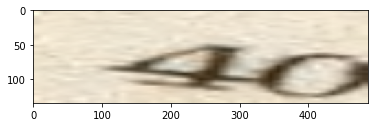

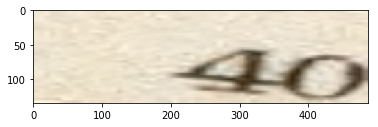

image index 683
Matched before: $40$
Matched after:$1o$
Ground truth:40
Image Dir before:0
Image Dir after:0
Distance before:0.28892563721469977
Distance after:0.23749082494111173
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


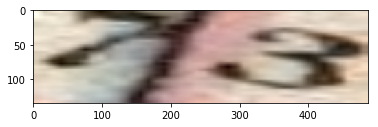

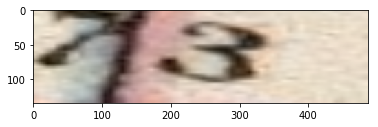

image index 709
Matched before: $73$
Matched after:$R$
Ground truth:73
Image Dir before:0
Image Dir after:0
Distance before:0.12240855971609921
Distance after:0.008821323414823667
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


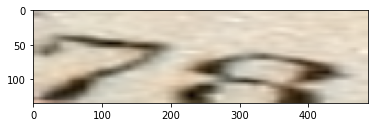

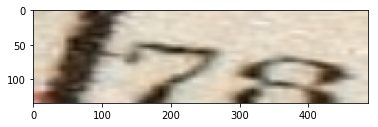

image index 720
Matched before: $78$
Matched after:$R$
Ground truth:78
Image Dir before:0
Image Dir after:0
Distance before:0.036696036667549614
Distance after:0.0026564230692830426
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


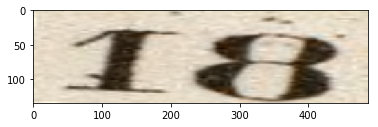

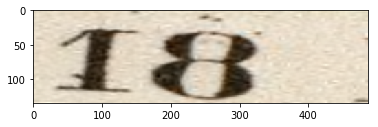

image index 893
Matched before: $18$
Matched after:$188$
Ground truth:18
Image Dir before:0
Image Dir after:0
Distance before:0.12044639071387808
Distance after:0.10577588633116974
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


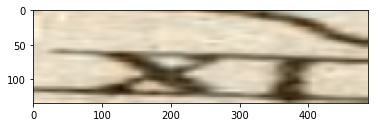

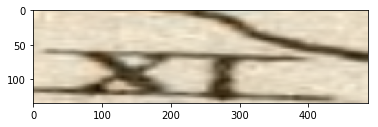

image index 947
Matched before: $XI$
Matched after:$XII$
Ground truth:XI
Image Dir before:0
Image Dir after:0
Distance before:0.14487627642938472
Distance after:0.07172161062405558
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


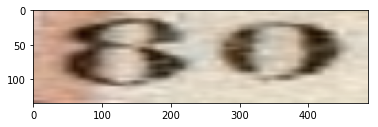

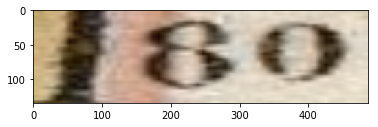

image index 963
Matched before: $80$
Matched after:$180$
Ground truth:80
Image Dir before:0
Image Dir after:0
Distance before:0.08978409509323237
Distance after:0.07903003656819096
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


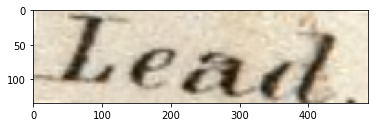

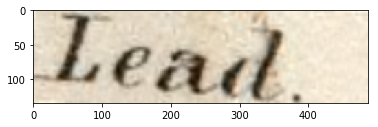

image index 972
Matched before: $Lead$
Matched after:$Leada$
Ground truth:Lead
Image Dir before:-1
Image Dir after:-1
Distance before:0.08600227785744474
Distance after:0.07020425509337092
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


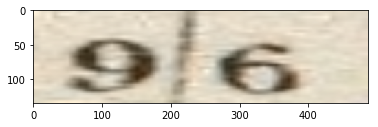

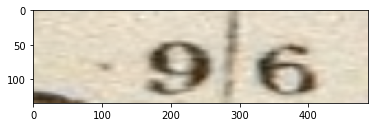

image index 1022
Matched before: $96$
Matched after:$gos$
Ground truth:96
Image Dir before:0
Image Dir after:0
Distance before:0.25635460066629245
Distance after:0.2491971927972928
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


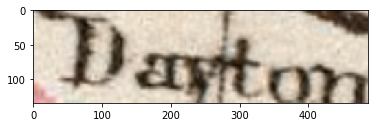

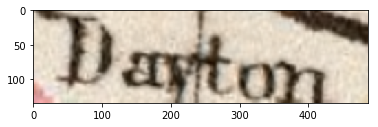

image index 1066
Matched before: $Dayton$
Matched after:$Datton$
Ground truth:Dayton
Image Dir before:-1
Image Dir after:0
Distance before:0.06506994719353398
Distance after:0.021362086186244467
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


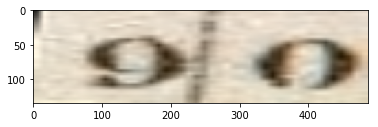

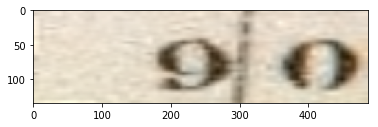

image index 1110
Matched before: $90$
Matched after:$oo$
Ground truth:90
Image Dir before:0
Image Dir after:0
Distance before:0.25399923256192813
Distance after:0.22665907065783308
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


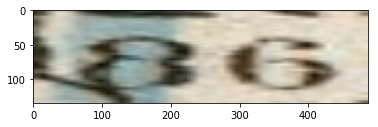

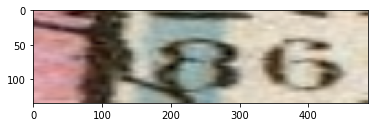

image index 1159
Matched before: $86$
Matched after:$16$
Ground truth:86
Image Dir before:0
Image Dir after:0
Distance before:0.1576457697094391
Distance after:0.06477771471377214
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


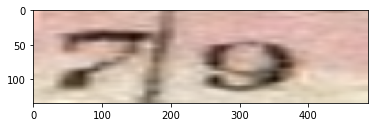

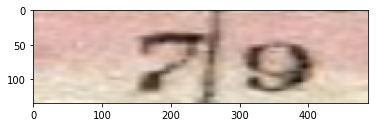

image index 1202
Matched before: $79$
Matched after:$111$
Ground truth:79
Image Dir before:0
Image Dir after:0
Distance before:0.3276222107403143
Distance after:0.24775941982873373
------------------------------------------------------------------------
------------------------------------------------------------------------
20


In [35]:
print "Incorrectly classified before and Incorrectly classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 1 \
    and match_report_after[5][i] == 0:
        count += 1
        print "************************************************************************"
        print "************************************************************************"
        q = np.transpose(images_before[i],(1,2,0))
        q1 = np.transpose(images_after[i],(1,2,0))
        plt.imshow(q)
        plt.show()
        plt.imshow(q1)
        plt.show()
        print 'image index', i
        print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
        print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
        print "Ground truth:" + str(words[i])
        print "Image Dir before:" + str(match_report_before[2][i])
        print "Image Dir after:" + str(match_report_after[2][i])
        print "Distance before:" + str(match_report_before[4][i])
        print "Distance after:" + str(match_report_after[4][i])
        print "------------------------------------------------------------------------"
        print "------------------------------------------------------------------------"
        
print count
        

In [ ]:
print "Incorrectly classified before and Correctly classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 0 \
    and match_report_after[5][i] == 1:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[i],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(words[i])
#         print "Image Dir before:" + str(match_report_before[2][i])
#         print "Image Dir after:" + str(match_report_after[2][i])
#         print "Distance before:" + str(match_report_before[4][i])
#         print "Distance after:" + str(match_report_after[4][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count   

In [ ]:
print "Incorrectly classified before and Almost correctly classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 0 \
    and match_report_after[5][i] == 2:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[i],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(words[i])
#         print "Image Dir before:" + str(match_report_before[2][i])
#         print "Image Dir after:" + str(match_report_after[2][i])
#         print "Distance before:" + str(match_report_before[4][i])
#         print "Distance after:" + str(match_report_after[4][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count

In [ ]:
print "Correctly classified before and Incorrectly classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 1 \
    and match_report_after[5][i] == 0:
        count += 1
        print "************************************************************************"
        print "************************************************************************"
        q = np.transpose(images_before[i],(1,2,0))
        q1 = np.transpose(images_after[i],(1,2,0))
        plt.imshow(q)
        plt.show()
        plt.imshow(q1)
        plt.show()
        print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
        print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
        print "Ground truth:" + str(words[i])
        print "Image Dir before:" + str(match_report_before[2][i])
        print "Image Dir after:" + str(match_report_after[2][i])
        print "Distance before:" + str(match_report_before[4][i])
        print "Distance after:" + str(match_report_after[4][i])
        print "------------------------------------------------------------------------"
        print "------------------------------------------------------------------------"
        
print count

In [ ]:
print "Correctly classified before and Correctly classified after"
import matplotlib.pyplot as plt
qualified_ids = match_report_before[2]
ground_truth = match_report_before[6]
count = 0
for i in range(len(qualified_ids)):
    if match_report_before[5][i] == 1 \
    and match_report_after[5][i] == 1:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[i],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(words[i])
#         print "Image Dir before:" + str(match_report_before[2][i])
#         print "Image Dir after:" + str(match_report_after[2][i])
#         print "Distance before:" + str(match_report_before[4][i])
#         print "Distance after:" + str(match_report_after[4][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count

In [ ]:
print "Correctly classified before and Almost classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 1 \
    and match_report_after[5][i] == 2:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[i],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(words[i])
#         print "Image Dir before:" + str(match_report_before[2][i])
#         print "Image Dir after:" + str(match_report_after[2][i])
#         print "Distance before:" + str(match_report_before[4][i])
#         print "Distance after:" + str(match_report_after[4][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count

In [ ]:
print "Almost classified before and In-correctly classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 2 \
    and match_report_after[5][i] == 0:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[i],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Image Index: " + str(i)
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(words[i])
#         print "Image Dir before:" + str(match_report_before[2][i])
#         print "Image Dir after:" + str(match_report_after[2][i])
#         print "Distance before:" + str(match_report_before[4][i])
#         print "Distance after:" + str(match_report_after[4][i])
#         print "\nAll Distances Before:" + str(match_report_before[6][i])
#         print "\nAll Distances After:" + str(match_report_after[6][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count

In [ ]:
print "Almost classified before and Correctly classified after"
import matplotlib.pyplot as plt
qualified_ids = match_report_before[2]
ground_truth = match_report_before[6]
count = 0
for i in range(len(qualified_ids)):
    if match_report_before[5][i] == 2 \
    and match_report_after[5][i] == 1:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[qualified_ids[i]],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(ground_truth[i])
#         print "Image Dir before:" + str(match_report_before[3][i])
#         print "Image Dir after:" + str(match_report_after[3][i])
#         print "Distance before:" + str(match_report_before[7][i])
#         print "Distance after:" + str(match_report_after[7][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count

In [ ]:
print "Almost classified before and Almost classified after"
import matplotlib.pyplot as plt
qualified_ids = match_report_before[2]
ground_truth = match_report_before[6]
count = 0
for i in range(len(qualified_ids)):
    if match_report_before[5][i] == 2 \
    and match_report_after[5][i] == 2:
        count += 1
#         print "************************************************************************"
#         print "************************************************************************"
#         q = np.transpose(images_before[qualified_ids[i]],(1,2,0))
#         q1 = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()
#         plt.imshow(q1)
#         plt.show()
#         print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
#         print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
#         print "Ground truth:" + str(ground_truth[i])
#         print "Image Dir before:" + str(match_report_before[3][i])
#         print "Image Dir after:" + str(match_report_after[3][i])
#         print "Distance before:" + str(match_report_before[7][i])
#         print "Distance after:" + str(match_report_after[7][i])
#         print "------------------------------------------------------------------------"
#         print "------------------------------------------------------------------------"
        
print count